In [124]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [157]:
data = pd.read_csv('./Titanic.csv')[["PClass","Age","SexCode","Survived"]]

data = data.dropna(how='any')
mapper = {'1st':1, '2nd':2,'3rd':3}
data = data[data['PClass'].isin(mapper.keys())]
data['PClass'] = list(map( lambda v: mapper[v], data['PClass'].values))
data['Age'] = np.log(data['Age'])
data.loc[data.Survived == 0, 'Survived'] = -1

X = np.asmatrix(data.drop('Survived', axis=1))
y = np.asmatrix(data['Survived']).T
data.head()


,PClass,Age,SexCode,Survived
0,1,3.367296,1,1
1,1,0.693147,1,-1
2,1,3.401197,0,-1
3,1,3.218876,1,-1
4,1,-0.083382,0,1


In [158]:
#np.linalg.inv(X.T.dot(X).values).dot(X.T).dot(y)


w = np.linalg.inv(X.T * X) * X.T *y
w

matrix([[-0.22969771],
        [-0.0396325 ],
        [ 1.09325418]])

In [159]:
yhat = np.sign(X*w)
np.sum(np.multiply(yhat, y)>0)/y.size
#np.sum(y)
#def error(X, w):
    

0.77910052910052907

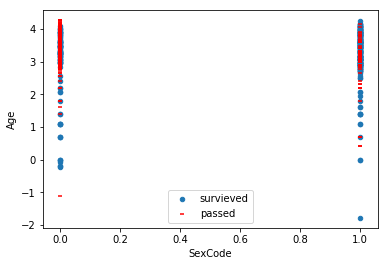

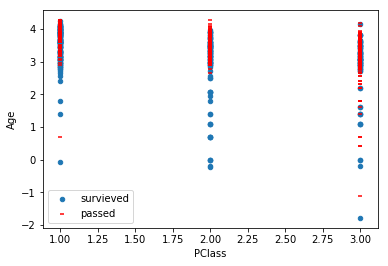

In [160]:
ax = data[y>0].plot(kind='scatter', x="SexCode",y="Age", label='survieved')
data[y<=0].plot(kind='scatter', x="SexCode",y="Age", color='red', marker='_', label='passed', ax=ax)

ax = data[y>0].plot(kind='scatter', x="PClass",y="Age", label='survieved')
data[y<=0].plot(kind='scatter', x="PClass",y="Age", color='red', marker='_', label='passed', ax=ax)


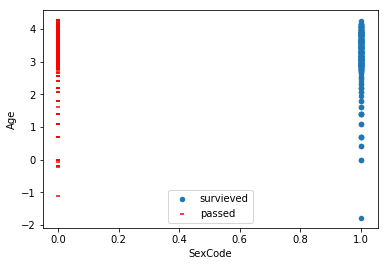

In [163]:
ax = data[yhat>0].plot(kind='scatter', x="SexCode",y="Age", label='survieved')
data[yhat<=0].plot(kind='scatter', x="SexCode",y="Age", color='red', marker='_', label='passed', ax=ax)
